# Problem Description

The data consists of labelled amino acid sequences. Each sequence has a unique ID, the amino acid sequence, the organism it came from and the label. You must predict the label for the test set. Labels consist of one of 20 classes. There are ten organisms, 8 in the training set and 2 in the test set. Sequences above a set length have been excluded from this dataset

2-Objective

Create a model that classify the amino acid sequence

In [1]:
# For Google Colab

#!pip install tensorflow-gpu==2.3.0 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time, logging, gc ,os


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instadeep-enzyme-classification-challenge/Train (4).csv
/kaggle/input/instadeep-enzyme-classification-challenge/Test (3).csv
/kaggle/input/instadeep-enzyme-classification-challenge/SampleSubmission (3).csv


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D,LSTM
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [4]:
# Ensure Reproducibility

def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [5]:
DIR = '../input/instadeep-enzyme-classification-challenge/'
train=pd.read_csv(DIR+'Train (4).csv')
test=pd.read_csv(DIR+'Test (3).csv')
sub=pd.read_csv(DIR+'SampleSubmission (3).csv')

# EDA

In [6]:
print('Train size: ', len(train))
print('Test size: ', len(test))

Train size:  858777
Test size:  253146


In [7]:
train.head(3)

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL
0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,creature9,class11
1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,creature3,class13
2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,creature3,class16


In [8]:
train.describe()

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL
count,858777,858777,858777,858777
unique,858777,816700,8,20
top,JVQIYX53,FFRENLAFPEGEAREFPSEQTRAIGPTRGEPQVWGRSSNSLSEAGG...,creature8,class19
freq,1,201,140738,256273


In [9]:
#Check if ther'is null values
train.isnull().sum()

SEQUENCE_ID    0
SEQUENCE       0
CREATURE       0
LABEL          0
dtype: int64

In [10]:
#Remove redundant samples
train=train.drop_duplicates(subset=['SEQUENCE', 'LABEL'], keep='first')

In [11]:
# check duplicate rows

print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [12]:
#example of protein sequence
train.SEQUENCE[0]

'MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLTTGSRQRMARIDVGVRLVGAIESIGDLIVRELPDDEDWMNSWKSHFKILRVGKRLVIKPTWLELDETIKLDDIVIELDPGIAFGTGYHPTTDTCMQAMEQHITPGMAVLDLGTGSGILAITAMKLGAGKVTALDIDSQAVSAARRNFKRTGISKQIRLGQGSVPHPTAPAAEFDLAVANISARGVVDRCPFILTALKPGALFIASGLLATQKPEVANAVEPLGFSLVSEWPQEEWVTLLYRAPDSPIVASE'

In [13]:
# creating a new column for analysis purpose

train['LENGTH'] = train['SEQUENCE'].apply(lambda x: len(x))

test['LENGTH'] = test['SEQUENCE'].apply(lambda x: len(x))

In [14]:
# process the creature column

train['CREATURE'] = train['CREATURE'].apply(lambda x: x[8])
test['CREATURE'] = test['CREATURE'].apply(lambda x: x[8])

train['CREATURE'] = train['CREATURE'].astype('int')
test['CREATURE'] = test['CREATURE'].astype('int')

In [15]:
# Next, we need to encode the sequence into vectors

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train['LABEL'] = encoder.fit_transform(train['LABEL'])

In [16]:
labels = train['LABEL'].unique()
label_list = {x: list(encoder.inverse_transform(np.array(x).reshape(1,)))[0] for x in labels}

label_list

{3: 'class11',
 5: 'class13',
 8: 'class16',
 4: 'class12',
 11: 'class19',
 0: 'class0',
 18: 'class8',
 19: 'class9',
 13: 'class3',
 10: 'class18',
 12: 'class2',
 2: 'class10',
 16: 'class6',
 15: 'class5',
 17: 'class7',
 9: 'class17',
 7: 'class15',
 1: 'class1',
 14: 'class4',
 6: 'class14'}

In [17]:
train.head()

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL,LENGTH
0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,9,3,296
1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,3,5,306
2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,3,8,348
3,0003XVE3,MKNTSLSTTLTMNDTIAAIATPLGKGAISIIKISGHNALNILKQLT...,3,4,461
4,00049BS0,MGNRLTKIYTKTGDSGLTGLADGSRTEKDSLRIFVIGDVDELNSLL...,8,5,184


# Exploratory Data Analysis

In [18]:
train.describe(include='all')

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL,LENGTH
count,816950,816950,816950.000000,816950.000000,816950.000000
unique,816950,816700,NaN,NaN,NaN
top,JVQIYX53,MLYKGDTLYLDWLEDGIAELVFDAPGSVNKLDTATVASLGQALEVL...,NaN,NaN,NaN
freq,1,2,NaN,NaN,NaN
mean,NaN,NaN,4.470948,10.208423,402.879796
std,NaN,NaN,2.986327,5.150080,208.101618
min,NaN,NaN,0.000000,0.000000,16.000000
25%,NaN,NaN,2.000000,6.000000,262.000000
50%,NaN,NaN,4.000000,11.000000,379.000000
75%,NaN,NaN,8.000000,14.000000,476.000000


In [19]:
test.describe(include='all')

,SEQUENCE_ID,SEQUENCE,CREATURE,LENGTH
count,253146,253146,253146.000000,253146.000000
unique,253146,253078,NaN,NaN
top,XX4Z7O3A,ASDNDEHYDPGKRITYRSKVKDQNYYSVAVNAGYYVTPNAKVYVEG...,NaN,NaN
freq,1,6,NaN,NaN
mean,NaN,NaN,6.614942,379.370261
std,NaN,NaN,0.486610,214.976543
min,NaN,NaN,6.000000,19.000000
25%,NaN,NaN,6.000000,232.000000
50%,NaN,NaN,7.000000,339.000000
75%,NaN,NaN,7.000000,474.000000


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='CREATURE', ylabel='count'>

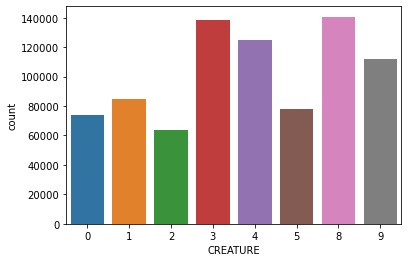

In [20]:
# countplot of train's creature category

sns.countplot(train['CREATURE'])

In [21]:
train.groupby('CREATURE').count()['SEQUENCE'] # How many in each oganism?

CREATURE
0     73742
1     84961
2     63851
3    138447
4    125185
5     78092
8    140711
9    111961
Name: SEQUENCE, dtype: int64

### The creature distribution is irregular

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='CREATURE', ylabel='count'>

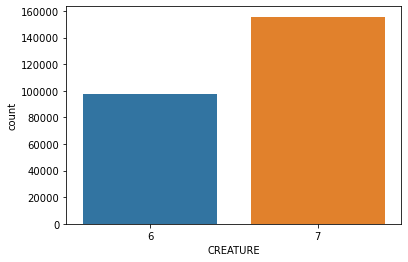

In [22]:
sns.countplot(test['CREATURE'])

In [23]:
test.groupby('CREATURE').count()['SEQUENCE'] # How many in each oganism?

CREATURE
6     97476
7    155670
Name: SEQUENCE, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='LABEL', ylabel='count'>

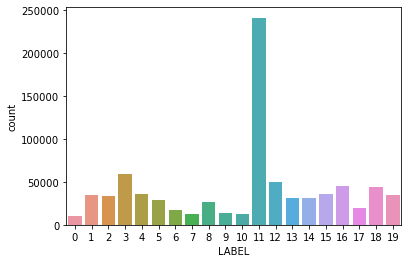

In [24]:
# countplot of Labels

sns.countplot(train['LABEL'])

### One label (11) has a very large volume and could cause a problem for our model. The class labels for the training dataset are imbalanced

<AxesSubplot:>

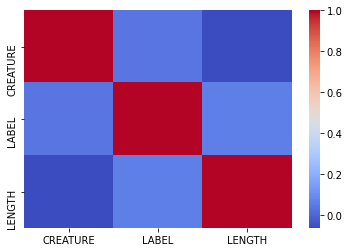

In [25]:
# heatmap

sns.heatmap(train.corr(), cmap='coolwarm')

<AxesSubplot:>

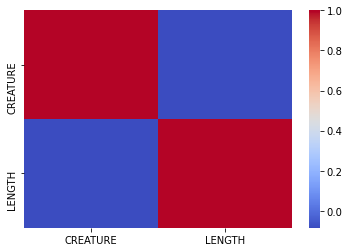

In [26]:
sns.heatmap(test.corr(), cmap='coolwarm')

## Heatmap shows mininmal correlation between the sequence length,  the creature type and the class label

# Encoding the Sequence Column and spliting the data

In [27]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')
  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

def plot_code_freq(df, data_name):
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

In [28]:
train_code_freq = get_code_freq(train['SEQUENCE'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 24


,Code,Freq
0,L,33132419
1,A,29148848
2,G,24797034
3,V,22652087
4,E,22130013
5,I,21153868
6,K,19490664
7,D,18311065
8,R,18307046
9,S,17326939


In [29]:
test_code_freq = get_code_freq(test['SEQUENCE'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 22


,Code,Freq
0,L,10305566
1,A,9796485
2,G,7315191
3,V,6659944
4,E,5978780
5,R,5927049
6,D,5447698
7,S,5176983
8,I,5127870
9,T,4790625


In [30]:
'''plt.subplot(1, 2, 1)
plot_code_freq(train_code_freq, 'Train')
plt.subplot(1, 2, 2)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()'''

"plt.subplot(1, 2, 1)\nplot_code_freq(train_code_freq, 'Train')\nplt.subplot(1, 2, 2)\nplot_code_freq(test_code_freq, 'Test')\n\nplt.subplots_adjust(right=3.0)\nplt.show()"

* amino acids  (X, U, B, Z)  are present in very less quantity
* amino acids  (B, Z) are presented only in the training set 

In [31]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']#,'B','X','U','Z']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1
  return char_dict
char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [32]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data.values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [33]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()

In [34]:
#Split our data into train and validation 
X_train, X_val, y_train, y_val = train_test_split(train.SEQUENCE,train.LABEL, test_size=0.2, random_state=42,stratify=train['LABEL'])

In [35]:
# encode the data
# fit vectorizer to X_train

#vectorizer.fit(X_train)

#X_train = vectorizer.transform(X_train).toarray()
#X_val = vectorizer.transform(X_val).toarray()
#test_data = vectorizer.transform(test.SEQUENCE).toarray()

In [36]:
X_train.shape

(653560,)

In [37]:
# encode our data
X_train = integer_encoding(X_train) 
X_val = integer_encoding(X_val) 
test_data = integer_encoding(test.SEQUENCE)

In [38]:
#we will take just the first 600 amino acid in the sequence
max_length = 500
train_pad = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(X_val, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_data, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((653560, 500), (163390, 500), (253146, 500))

In [39]:
# One hot encoding of label
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_train.shape, y_val.shape

((653560, 20), (163390, 20))

In [40]:
# Detect hardware, return appropriate distribution strategy
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on TPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1
REPLICAS:  8


In [41]:
if tpu:
    BATCH_SIZE = 128 * strategy.num_replicas_in_sync
else:
    BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BATCH_SIZE

1024

In [42]:
gc.collect()

62

In [43]:
# from sklearn.utils import class_weight

# labels= train.LABEL

#class_weights = dict(zip(np.unique(labels), class_weight.compute_class_weight('balanced',
 #                                                np.unique(labels),
  #                                               labels))) 

In [44]:
with strategy.scope():
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(21, 10, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, dropout=0.5, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,dropout=0.5)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')])

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 10)           210       
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 1024)         2142208   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 8,571,750
Trainable params: 8,571,750
Non-trainable params: 0
______________________________________________

In [45]:
es = []

es += [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=2,
                                   cooldown=2,
                                   verbose=1)]

es += [EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1e-4)]


es += [tf.keras.callbacks.ModelCheckpoint('Enzyme.h5', save_best_only=True, mode='min')]

model.fit(train_pad, y_train,epochs=100, batch_size=1024,validation_data=(val_pad,y_val),callbacks=es)

Epoch 1/100
639/639 [==============================] - 245s 362ms/step - loss: 2.5096 - accuracy: 0.2900 - val_loss: 2.2630 - val_accuracy: 0.3108
Epoch 2/100
639/639 [==============================] - 220s 345ms/step - loss: 2.1809 - accuracy: 0.3342 - val_loss: 1.4367 - val_accuracy: 0.5728
Epoch 3/100
639/639 [==============================] - 220s 345ms/step - loss: 1.4274 - accuracy: 0.5812 - val_loss: 0.7389 - val_accuracy: 0.7930
Epoch 4/100
639/639 [==============================] - 220s 345ms/step - loss: 0.8102 - accuracy: 0.7758 - val_loss: 0.4499 - val_accuracy: 0.8758
Epoch 5/100
639/639 [==============================] - 221s 345ms/step - loss: 0.5255 - accuracy: 0.8575 - val_loss: 0.3437 - val_accuracy: 0.9040
Epoch 6/100
639/639 [==============================] - 220s 345ms/step - loss: 0.3902 - accuracy: 0.8936 - val_loss: 0.2787 - val_accuracy: 0.9235
Epoch 7/100
639/639 [==============================] - 220s 345ms/step - loss: 0.3118 - accuracy: 0.9147 - val_loss: 0

In [46]:
new_model = keras.models.load_model('./Enzyme.h5')

In [47]:
pred = new_model.predict(test_pad, batch_size=1024)

In [48]:
pred.shape

(253146, 20)

In [49]:
pred = np.argmax(pred, axis=1)

In [50]:
sub.head()

,SEQUENCE_ID,LABEL
0,000LRRAI,NaN
1,000O8L4W,NaN
2,000UKB5J,NaN
3,00111SLH,NaN
4,001ELB0A,NaN


In [51]:
sub.LABEL = pred

In [52]:
sub.LABEL = sub.LABEL.apply(lambda x: label_list[x])

In [53]:
sub.head()

,SEQUENCE_ID,LABEL
0,000LRRAI,class15
1,000O8L4W,class10
2,000UKB5J,class10
3,00111SLH,class2
4,001ELB0A,class2


In [54]:
# Make a submission file

sub.to_csv('sub7.csv', index=False)